<a href="https://colab.research.google.com/github/Coburn1/AERO_489/blob/main/489_PR1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Assign Credit
Import Modules

In [ ]:
# Written by Coby Arnold
# Texas A&M University

import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as la
import cvxpy as cp

### Parameter Input

In [ ]:
L = 4 #Desired Length of the Beam
w = 1 #Desired Thickness of the Beam
P = 1 #Desired Applied Load on the end of the bar
Spacing = 1/4 #Ensures Even Spacing based on user input (CHANGE THIS FOR MESH)

Define Material Properties

In [ ]:
d_b = 1 # Bar Density [kg/m^3]
d_s = 1 # String Density [kg/m^3]

Generate Node Matrix

In [ ]:
xm = int(L/Spacing+1) #Number of nodes in the beam's X direction (must be evenly spaced)
ym = int(w/Spacing+1) #Number of nodes in the beam's Y direction (must be evenly spaced with X as well)
NP = xm*ym # Number of Points
print('Generating\n{} Nodes'.format(NP))

points = np.arange(0, NP, 1)
N = []
for i in points:
    N += [[i//ym, i%ym]]
N = np.matrix(N)*Spacing

Generating
85 Nodes


Generate Connection Matrix

In [ ]:
C = []
length = []
def mag(x1, y1, x2, y2):
    return ((x1 - x2)**2 + (y1 - y2)**2)**0.5

rad = (2*Spacing**2)**0.5
for i in range(len(N)):
    for j in range(i+1, len(N)):
        if mag(N[i, 0], N[i, 1], N[j, 0], N[j, 1]) < rad:
            length += [Spacing]
            Cxn = np.zeros(NP)
            Cxn[i] = 1
            Cxn[j] = -1
            C += [Cxn]
        elif mag(N[i, 0], N[i, 1], N[j, 0], N[j, 1]) == rad:
            length += [rad]
            Cxn = np.zeros(NP)
            Cxn[i] = 1
            Cxn[j] = -1
            C += [Cxn]
C = np.matrix(C)
length = np.array(length)

Generate Force and Stress Representations

In [ ]:
sig_b = cp.Variable(len(C), nonneg = True) # Stress For Bars
sig_s = cp.Variable(len(C), nonneg = True) # Stress For Strings

sig_b = cp.multiply(sig_b, length*length.T)
sig_s = cp.multiply(sig_s, length*length.T)

N = N.T
Force = np.zeros([2, NP]) # Force Matrix
Force[1, -3] = -P # Add Applied Load to Force Matrix


Rx = cp.Variable([2, NP]) # Created Reaction Force Matrix


Constraints = [N@C.T@cp.diag(sig_s)@C - N@C.T@cp.diag(sig_b)@C - Force - Rx == 0, Rx[:, np.arange(ym, NP, 1)] == 0] #Set up a solving connection


Cost = cp.norm(sig_b + sig_s, 1)
prob = cp.Problem(cp.Minimize(Cost), Constraints)
prob.solve()

320.00000024540896

Plotting the Results

Text(0, 0.5, 'Y Pos [ft]')

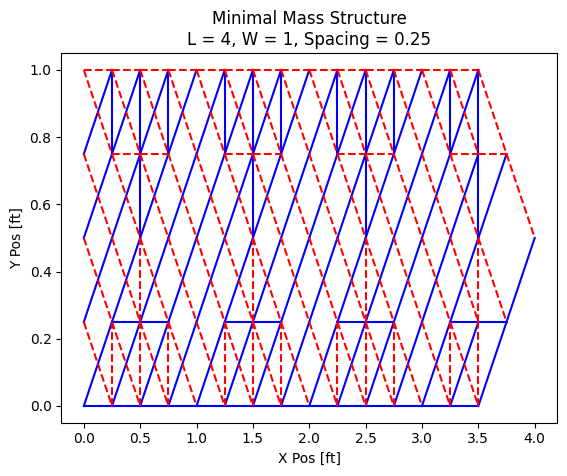

In [ ]:
# ~~~~~~~~~~~~~~~~~ Find Coords to plot ~~~~~~~~~~~~~~~~~ #
plt.figure(1)
Bars = sig_b.value.round(4).tolist()
Strings = sig_s.value.round(4).tolist()


num_beams = len(C)

for i in range(len(Bars)):
    if Bars[i] != 0:
        xp = []
        yp = []
        check = C[i].tolist()[0]
        for j in range(NP):
            if check[j] != 0:
                xp += [N[0, j]]
                yp += [N[1, j]]
        plt.plot(xp, yp, 'b-')

for i in range(len(Strings)):
    if Strings[i] != 0:
        xp = []
        yp = []
        check = C[i].tolist()[0]
        for j in range(NP):
            if check[j] != 0:
                xp += [N[0, j]]
                yp += [N[1, j]]
        plt.plot(xp, yp, 'r--')
plt.title('Minimal Mass Structure\nL = {}, W = {}, Spacing = {}'.format(L, w, Spacing))


plt.xlabel('X Pos [ft]')
plt.ylabel('Y Pos [ft]')